## Final Project Submission

Please fill out:
* __Student name:__ Cassarra Groesbeck
* __Student pace:__ Part Time (Flex)
* __Scheduled project review date/time:__ 
* __Instructor name:__ Claude Fried
* __Blog post URL:__ https://medium.com/@cassigroesbeck/data-science-i-did-it-for-the-money-57c0a26f9118


In [1]:
# potential needed imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
import sqlite3
import seaborn as sns
import numpy as np

# plot styles
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-talk')

%matplotlib inline

#  -------- Analysis of Affecting Factors of Films Worldwide Gross --------

# Overview
The goal of this project is to aid _The Microsoft Production Company_ (TMPC) in optimizing the profitability of future films. The measure used to evaluate profitability for this project is worldwide gross of films. Worldwide gross has been chosen because, presumably, increased worldwide gross yields a higher return on investment. Furthermore, increased worldwide popularity likely results in boosted global merchandising opportunities, creating additional revenue sources. 

The following factors were explored to determine if and how they impact worldwide gross: 
- Production Budget
- Month of Release
- Month of Release grouped by Genre
- Rating
- Production Budget & Worldwide Gross, Grouped by Rating


# Business Problem
To begin creating original video content, Microsoft has decided to create a new movie studio: _The Microsoft Production Company_ (TMPC) . TMPC needs an assessment of the factors which contribute to a films success.

# Data
This project used data from:
-	__The Numbers__
 - 5,782 films from 1915 to 2020
-	__Rotten Tomatoes__
 -	1,559 films from 1921 to 2018
-	__IMDb__
 -	98,940 films (unknown timeframe) 

## Import Needed Data & Assign Data Frame Names

### The Numbers = tn

In [2]:
# data from: The Numbers
tn = pd.read_csv('zippedData/tn.movie_budgets.csv.gz').drop_duplicates().drop(['id', 'domestic_gross'], axis=1)

#check that it has relevent information
tn.tail()

,release_date,movie,production_budget,worldwide_gross
5777,"Dec 31, 2018",Red 11,"$7,000",$0
5778,"Apr 2, 1999",Following,"$6,000","$240,495"
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338"
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0
5781,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041"


### Rotten Tomatoes = rt

In [3]:
# data from: Rotten Tomatoes
rt = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t').drop_duplicates()\
.drop(['id', 'currency', 'box_office', 'studio', 'dvd_date', 'writer', 'synopsis'], axis=1).dropna(axis=0)

#check that it has relevent information
rt.tail()

,rating,genre,director,theater_date,runtime
1553,PG,Comedy,James Lapine,"Jun 4, 1993",95 minutes
1554,PG-13,Action and Adventure|Comedy|Western,Barry Sonnenfeld,"Jun 30, 1999",107 minutes
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,"Jul 23, 1993",88 minutes
1557,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,"Jan 1, 1962",111 minutes
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,"Apr 1, 1993",101 minutes


### IMDb = imdb

In [4]:
# data from: imdb
conn = sqlite3.connect('zippedData/im.db')# join directors d, and persons p, select primary_name as director
imdb= pd.read_sql('''
    SELECT a.title, genres, runtime_minutes, p.primary_name as director
    FROM movie_basics b
    JOIN movie_akas a 
    ON b.movie_id = a.movie_id
    JOIN directors d 
    ON d.movie_id = a.movie_id
    JOIN persons p
    ON p.person_id = d.person_id
    WHERE ((language is 'en') | (primary_title = title)) & (runtime_minutes != 'Nan')
    GROUP BY a.movie_id
''', conn)

#check that it has relevent information
imdb.tail()

,title,genres,runtime_minutes,director
98943,Padmavyuhathile Abhimanyu,Drama,130.0,Vineesh Aaradya
98944,Nepal - Homebird,Documentary,52.0,Andrea Leichtfried
98945,A Cherry Tale,Documentary,85.0,Eva Mulvad
98946,Vida em Movimento,Documentary,70.0,Eduardo Rajabally
98947,The Rehearsal,Drama,51.0,Tamar Guimaraes


## Clean Data Frame's for Analysis:
Most columns needed for analysis have all been given a prefix 'p_' (prepped for analysis), this was simply for ease of tracking which columns had been 'cleaned'. Other prefixes occationally used for differentiating which db it is associated with.  Columns were renamed when possible, otherwise new columns was created and original columns dropped. 

### Clean tn (The Numbers):

__Rename__ existing column(s):

In [5]:
# ----------rename column(s) which already exist------------------------------
tn.rename(columns={"movie": "p_title"}, inplace=True) 

__Add__ new column(s) with cleaned data:

In [6]:
# ----------convert: production_budget & worldwide_gross to integer-----------
# make production_budget list as int
p_prod_budg = [int(i[1:].replace(',', '')) for i in tn.production_budget]

# make worldwide_gross list as int
p_ww_gross = [int(i[1:].replace(',', '')) for i in tn.worldwide_gross]

# add new column(s)
tn['p_prod_budg'] = p_prod_budg
tn['p_ww_gross'] = p_ww_gross

In [7]:
# ----------add 'p_date' column: yyyy-mm-dd, & 'p_month'---------------------
# drop NaN if any
tn.release_date.dropna(axis=0, inplace=True)

# add new column(s): 'p_date' & 'p_month'
tn['p_date'] = pd.to_datetime(tn['release_date'], yearfirst=True)
tn['p_month'] = pd.DatetimeIndex(tn['p_date']).month

__Check__ new column(s) were added before dropping original column(s):

In [8]:
# check new column(s) before dropping original column(s):
tn.tail()

,release_date,p_title,production_budget,worldwide_gross,p_prod_budg,p_ww_gross,p_date,p_month
5777,"Dec 31, 2018",Red 11,"$7,000",$0,7000,0,2018-12-31,12
5778,"Apr 2, 1999",Following,"$6,000","$240,495",6000,240495,1999-04-02,4
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338",5000,1338,2005-07-13,7
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,1400,0,2015-09-29,9
5781,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041",1100,181041,2005-08-05,8


If all is well, __Drop__ original column(s):

In [9]:
# remove old column(s)
tn.drop(['production_budget', 'worldwide_gross', 'release_date'], axis=1, inplace=True)

__Final check__ to ensure cleaned DF has required columns, in correct format.

In [10]:
# check cleaned DF
tn.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month
5777,Red 11,7000,0,2018-12-31,12
5778,Following,6000,240495,1999-04-02,4
5779,Return to the Land of Wonders,5000,1338,2005-07-13,7
5780,A Plague So Pleasant,1400,0,2015-09-29,9
5781,My Date With Drew,1100,181041,2005-08-05,8


### Clean rt (Rotten Tomatoes):

__Rename__ existing column(s):

In [11]:
# ----------rename column(s) which already exist------------------------------
rt.rename(columns={"genre": "rt_genre"}, inplace=True)

__Add__ new column(s) with cleaned data:

In [12]:
# ----------add 'p_date' column-------------------------------------------------
# drop NaN if any
rt['theater_date'].dropna(axis=0, inplace=True)

# add new 'p_date' column
rt['p_date'] = pd.to_datetime(rt['theater_date'], yearfirst=True)

In [13]:
# ----------add 'p_runtime_mins' column (convert to float to match imdb)-----
# drop NaN if any
rt['runtime'].dropna(axis=0, inplace=True)

# make list and add column
rt_runtime = [float(i[:3]) for i in rt.runtime]
rt['p_runtime_mins'] = rt_runtime

__Check__ new column(s) were added before dropping original column(s):

In [14]:
rt.tail()

,rating,rt_genre,director,theater_date,runtime,p_date,p_runtime_mins
1553,PG,Comedy,James Lapine,"Jun 4, 1993",95 minutes,1993-06-04,95.0
1554,PG-13,Action and Adventure|Comedy|Western,Barry Sonnenfeld,"Jun 30, 1999",107 minutes,1999-06-30,107.0
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,"Jul 23, 1993",88 minutes,1993-07-23,88.0
1557,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,"Jan 1, 1962",111 minutes,1962-01-01,111.0
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,"Apr 1, 1993",101 minutes,1993-04-01,101.0


If all is well, __Drop__ original column(s):

In [15]:
# remove old columns
rt.drop(['runtime', 'theater_date'], axis=1, inplace=True)

__Final check__ to ensure cleaned DF has required columns, in correct format.

In [16]:
rt.tail()

,rating,rt_genre,director,p_date,p_runtime_mins
1553,PG,Comedy,James Lapine,1993-06-04,95.0
1554,PG-13,Action and Adventure|Comedy|Western,Barry Sonnenfeld,1999-06-30,107.0
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,1993-07-23,88.0
1557,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,1962-01-01,111.0
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,1993-04-01,101.0


### Clean imdb (IMDb: Internet Movie Database):

__Rename__ existing column(s):

In [17]:
# ----------rename column(s) which already exist------------------------------
imdb.rename(columns={"title": "p_title", "runtime_minutes": "p_runtime_mins", "genres": "imdb_genres"}, \
            inplace=True) 

__Check:__

In [18]:
imdb.tail()

,p_title,imdb_genres,p_runtime_mins,director
98943,Padmavyuhathile Abhimanyu,Drama,130.0,Vineesh Aaradya
98944,Nepal - Homebird,Documentary,52.0,Andrea Leichtfried
98945,A Cherry Tale,Documentary,85.0,Eva Mulvad
98946,Vida em Movimento,Documentary,70.0,Eduardo Rajabally
98947,The Rehearsal,Drama,51.0,Tamar Guimaraes


# Join Data Frame's for Analysis:
### As the databases were joined together their sizes were reduced.  Information about the datasets used in analysis are below: 

### tn: 5,782 films from 1915 to 2020
-	__Used for:__
 -	_Positive Correlation Between Production Budge & Worldwide Gross_
 -	_Worldwide Gross grouped by Month of Release_


### tnimdb (tn joined with imdb): 2,967 films from 1915 to 2019
-	__Used for:__
 -	_Worldwide Gross per Month of Release, grouped by Genre_ (6,461)


### rttnimdb (rt joined with tnimdb): 33 films from 2010 to 2018
-	__Used for:__
 -	_Worldwide Gross grouped by Rating_
 -	_Correlation Between Production Budget & Worldwide Gross, Grouped by Rating_



### Join tn & imdb:

Very straight forward and simple, both DF's had movie titles. 

In [19]:
# ----------join on 'p_title'-------------------------------------------------
# set 'p_title' as index
tn.set_index('p_title', inplace=True)
imdb.set_index('p_title', inplace=True)

# assign name
tnimdb = tn.join(imdb, how='inner')

# reset indices
imdb = imdb.reset_index()
tn = tn.reset_index()
tnimdb = tnimdb.reset_index()

# ----------check-------------------------------------------------------------
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director
2962,Zookeeper,80000000,170805525,2011-07-08,7,"Comedy,Family,Romance",102.0,Frank Coraci
2963,Zoolander 2,50000000,55348693,2016-02-12,2,Comedy,101.0,Ben Stiller
2964,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli
2965,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard


### Join  rt & tnimdb:

This was a bit trickier of a join. Every time I tried to join with just two columns there were misalignments in some other column. Example: date and runtimes would match but genres would be off, or directors wouldn't match up. I rechecked this by joining in several different way. Ultimately I decided to join on three columns by first making a tuple of first two columns then adding the third. This drastically reduced the size down to 33 films. 

__Create__ multi indices for both DF's with: 'director', 'p_date', and 'p_runtime_mins'

In [20]:
# ----------create 'multi-index' columns on rt & tnimdb-----------------------
# tuple 'p_date' w/ 'p_runtime_mins'
rt_multi_index = list(zip(rt['p_date'], rt['p_runtime_mins']))
tnimdb_multi_index = list(zip(tnimdb['p_date'], tnimdb['p_runtime_mins']))

# add 'director' to tuple for multi index
rt_multi_index = list(zip(rt_multi_index, rt['director']))
tnimdb_multi_index = list(zip(tnimdb_multi_index, tnimdb['director']))

# add 'multi_index' columns to both df's
rt['multi_index'] = rt_multi_index
tnimdb['multi_index'] = tnimdb_multi_index

__Check__ both DF's to ensure columns were added

In [21]:
rt.tail()

,rating,rt_genre,director,p_date,p_runtime_mins,multi_index
1553,PG,Comedy,James Lapine,1993-06-04,95.0,"((1993-06-04 00:00:00, 95.0), James Lapine)"
1554,PG-13,Action and Adventure|Comedy|Western,Barry Sonnenfeld,1999-06-30,107.0,"((1999-06-30 00:00:00, 107.0), Barry Sonnenfeld)"
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,1993-07-23,88.0,"((1993-07-23 00:00:00, 88.0), Steve Barron)"
1557,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,1962-01-01,111.0,"((1962-01-01 00:00:00, 111.0), Gordon Douglas)"
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,1993-04-01,101.0,"((1993-04-01 00:00:00, 101.0), David Mickey Ev..."


In [22]:
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,multi_index
2962,Zookeeper,80000000,170805525,2011-07-08,7,"Comedy,Family,Romance",102.0,Frank Coraci,"((2011-07-08 00:00:00, 102.0), Frank Coraci)"
2963,Zoolander 2,50000000,55348693,2016-02-12,2,Comedy,101.0,Ben Stiller,"((2016-02-12 00:00:00, 101.0), Ben Stiller)"
2964,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli,"((2006-08-11 00:00:00, 96.0), Pedro Morelli)"
2965,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,"((2006-08-11 00:00:00, 158.0), Prashanth Raj)"
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,"((2016-03-04 00:00:00, 108.0), Byron Howard)"


__Join__ on 'multi_index' column:

In [23]:
# ----------join rt to tnimdb ON 'multi_index'-------------------------------- 
# set 'multi_index' as index for both df's
tnimdb.set_index('multi_index', inplace=True)
rt.set_index('multi_index', inplace=True)

# assign name
rttnimdb = tnimdb.join(rt, how='inner', lsuffix='_tnimdb')

# reset indices
rt = rt.reset_index()
tnimdb = tnimdb.reset_index()
rttnimdb = rttnimdb.reset_index()

__Check:__ visually check that genres from each DF ('imdb_genres' & 'rt_genre') are similar

In [24]:
rttnimdb.tail()

,multi_index,p_title,p_prod_budg,p_ww_gross,p_date_tnimdb,p_month,imdb_genres,p_runtime_mins_tnimdb,director_tnimdb,rating,rt_genre,director,p_date,p_runtime_mins
28,"((2013-07-26 00:00:00, 104.0), Maggie Carey)",The To Do List,1500000,4128828,2013-07-26,7,"Comedy,Romance",104.0,Maggie Carey,R,Comedy,Maggie Carey,2013-07-26,104.0
29,"((2010-12-10 00:00:00, 103.0), Florian Henckel...",The Tourist,100000000,278731369,2010-12-10,12,"Action,Adventure,Thriller",103.0,Florian Henckel von Donnersmarck,PG-13,Action and Adventure|Mystery and Suspense|Romance,Florian Henckel von Donnersmarck,2010-12-10,103.0
30,"((2013-08-23 00:00:00, 109.0), Edgar Wright)",The World's End,20000000,47508505,2013-08-23,8,"Action,Comedy,Sci-Fi",109.0,Edgar Wright,R,Comedy,Edgar Wright,2013-08-23,109.0
31,"((2014-06-20 00:00:00, 106.0), Tim Story)",Think Like a Man Too,24000000,70027933,2014-06-20,6,"Comedy,Romance",106.0,Tim Story,PG-13,Comedy|Romance,Tim Story,2014-06-20,106.0
32,"((2015-08-28 00:00:00, 96.0), Max Joseph)",We Are Your Friends,2000000,10153415,2015-08-28,8,"Drama,Music,Romance",96.0,Max Joseph,R,Drama,Max Joseph,2015-08-28,96.0


__Drop__ 'multi_index' columns from all DF's (they are no longer needed)

In [25]:
# drop 'multi_index' columns
rt.drop('multi_index', axis=1, inplace=True)
tnimdb.drop('multi_index', axis=1, inplace=True)
rttnimdb.drop('multi_index', axis=1, inplace=True)

__Final check__

In [26]:
rttnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date_tnimdb,p_month,imdb_genres,p_runtime_mins_tnimdb,director_tnimdb,rating,rt_genre,director,p_date,p_runtime_mins
28,The To Do List,1500000,4128828,2013-07-26,7,"Comedy,Romance",104.0,Maggie Carey,R,Comedy,Maggie Carey,2013-07-26,104.0
29,The Tourist,100000000,278731369,2010-12-10,12,"Action,Adventure,Thriller",103.0,Florian Henckel von Donnersmarck,PG-13,Action and Adventure|Mystery and Suspense|Romance,Florian Henckel von Donnersmarck,2010-12-10,103.0
30,The World's End,20000000,47508505,2013-08-23,8,"Action,Comedy,Sci-Fi",109.0,Edgar Wright,R,Comedy,Edgar Wright,2013-08-23,109.0
31,Think Like a Man Too,24000000,70027933,2014-06-20,6,"Comedy,Romance",106.0,Tim Story,PG-13,Comedy|Romance,Tim Story,2014-06-20,106.0
32,We Are Your Friends,2000000,10153415,2015-08-28,8,"Drama,Music,Romance",96.0,Max Joseph,R,Drama,Max Joseph,2015-08-28,96.0


# Visual Analysis of Data:
__*Outliers have been removed from boxplots*__

### Positive Correlation Between Production Budget and Worldwide Gross: (5,782 films)

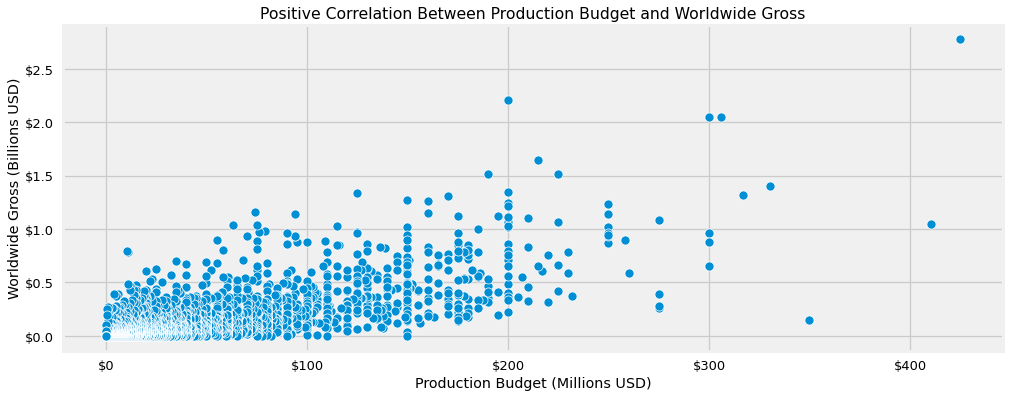

In [27]:
# initiate plot
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(x=tn['p_prod_budg']/1000000, y=tn['p_ww_gross']/1000000000, ax=ax)

# customize labels
ax.set_xlabel('Production Budget (Millions USD)')
ax.xaxis.set_major_formatter('${x:1.0f}') 
ax.set_ylabel('Worldwide Gross (Billions USD)')
ax.yaxis.set_major_formatter('${x}') 
ax.set_title('Positive Correlation Between Production Budget and Worldwide Gross');

### Worldwide Gross grouped by Month of Release: (5,782 films)

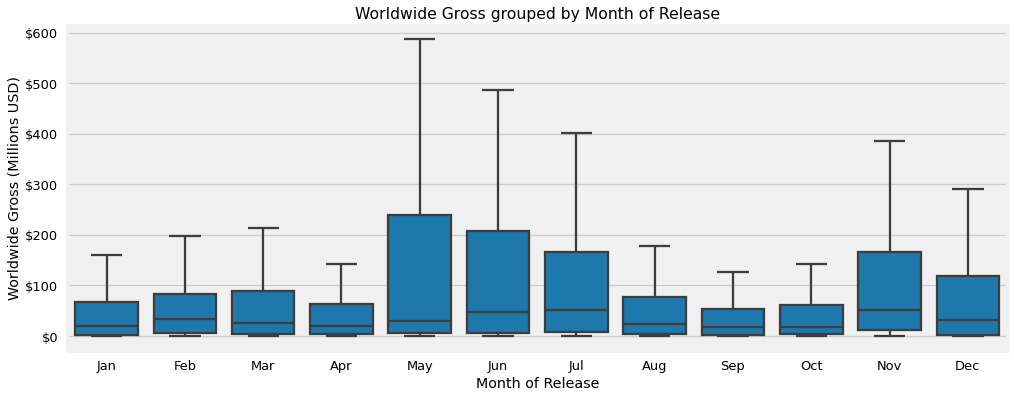

In [28]:
# use SQL to ORDER BY 'p_month' so it's Jan --> Dec:
pysqldf = lambda q: sqldf(q, globals())
q = """SELECT *
     FROM tn
     ORDER BY p_month;"""
tn = pysqldf(q)

# initiate plot
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=tn['p_month'], y=tn['p_ww_gross']/1000000, showfliers = False, ax=ax, color='#067ec4')

# customize labels
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Worldwide Gross grouped by Month of Release')
ax.set_xlabel("Month of Release")
ax.set_ylabel("Worldwide Gross (Millions USD)")
ax.yaxis.set_major_formatter('${x:1.0f}');

### Worldwide Gross per Month of Release, grouped by Genre:

To plot the genres individually, each film's genre categories needed to be separated. This resulted in the worldwide gross being duplicated with each genre. In order to compensate for these inflated values a new column was created that divided the worldwide gross equally among each films genres. In addition to using these divided-gross values for the plots below, they were also used to calculate each genres mean value, and the top raking genres were then based off of that mean value. 
 

### Seperating the genres:

__Drop__ rows that have none value

In [29]:
# before graphing need to split then explode 'imdb_genres'

# drop the row if 'imdb_genres' has None value 
# ----------make a list of none-value rows to drop----------------------------
genres = tnimdb['imdb_genres']
need_to_drop_these_rows = [index for index in range(len(genres)) if genres[index] == None]

# ----------drop non-value rows from 'need_to_drop_these_rows' list-----------
tnimdb.drop(labels=need_to_drop_these_rows, axis=0, inplace=True)

# ----------after drop, reset index-------------------------------------------
tnimdb.reset_index()

# check
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director
2962,Zookeeper,80000000,170805525,2011-07-08,7,"Comedy,Family,Romance",102.0,Frank Coraci
2963,Zoolander 2,50000000,55348693,2016-02-12,2,Comedy,101.0,Ben Stiller
2964,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli
2965,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard


__Add__ new columns: 
- 'genres_exploded' - seperated genres (multiple genres still group together but split on the comma which seperates them into differnt entities)
- 'gross_divided' - worldwide gross divided by the number of genres from 'genres_exploded'

In [30]:
# ------add new column: df = split on commas----------------------------------
tnimdb['genres_exploded'] = [clean_genres.split(',') for clean_genres in tnimdb['imdb_genres']]   


# ------new column with ww gross divided by number of genres------------------
tnimdb['gross_divided'] = [tnimdb['p_ww_gross'].iloc[i]//len(tnimdb['genres_exploded'].iloc[i]) \
                           for i in range(len(tnimdb))]

In [31]:
# check that new columns are there
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,genres_exploded,gross_divided
2962,Zookeeper,80000000,170805525,2011-07-08,7,"Comedy,Family,Romance",102.0,Frank Coraci,"[Comedy, Family, Romance]",56935175
2963,Zoolander 2,50000000,55348693,2016-02-12,2,Comedy,101.0,Ben Stiller,[Comedy],55348693
2964,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli,"[Animation, Comedy, Drama]",4168729
2965,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,"[Comedy, Drama, Romance]",4168729
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,"[Adventure, Animation, Comedy]",339809872


__Explode__ 'genres_exploded' seperating each genre into a new row (worldwide gross is duplicated in each new row)

In [32]:
# ----------explode the 'genres_exploded' column------------------------------
tnimdb = tnimdb.explode('genres_exploded', ignore_index=False)

__Final Check__ to ensure DF is as needed

In [33]:
# check that each genre is seperated
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,genres_exploded,gross_divided
2965,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,Drama,4168729
2965,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,Romance,4168729
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Adventure,339809872
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Animation,339809872
2966,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Comedy,339809872


### Plotting the exploded genres:
__Use SQL Lite query__ so genres are ordered alphabetically once plotted:

In [34]:
# use SQL so genres are alphabetized: ORDER BY month, genre:
# ----------JANUARY------------
q1 = """SELECT *
     FROM tnimdb
     ORDER BY p_month, genres_exploded;"""
tnimdb_sql = pysqldf(q1)

#check that all the info needed in here
tnimdb_sql.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,genres_exploded,gross_divided
6456,Django Unchained,100000000,449948323,2012-12-25 00:00:00.000000,12,"Drama,Western",165.0,Quentin Tarantino,Western,224974161
6457,Doc Holliday's Revenge,1000000,0,2014-12-31 00:00:00.000000,12,Western,84.0,David DeCoteau,Western,0
6458,The Ridiculous 6,60000000,0,2015-12-11 00:00:00.000000,12,"Comedy,Western",119.0,Frank Coraci,Western,0
6459,The Warrior's Way,42000000,8514325,2010-12-03 00:00:00.000000,12,"Action,Fantasy,Western",100.0,Sngmoo Lee,Western,2838108
6460,True Grit,35000000,252276928,2010-12-22 00:00:00.000000,12,"Adventure,Drama,Western",110.0,Ethan Coen,Western,84092309


__Create a dictionary__ of months with: 
- Keys: months spelled out 
- Values: months as intergers

In [35]:
# dictionary of months - words:integers
months_words_ints = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12       
}

__Create for loop__ to iterate over dictionary of months and plot each month individually:

( __<font color=gold>GOLD</font> &#9651;'s mark the mean__)

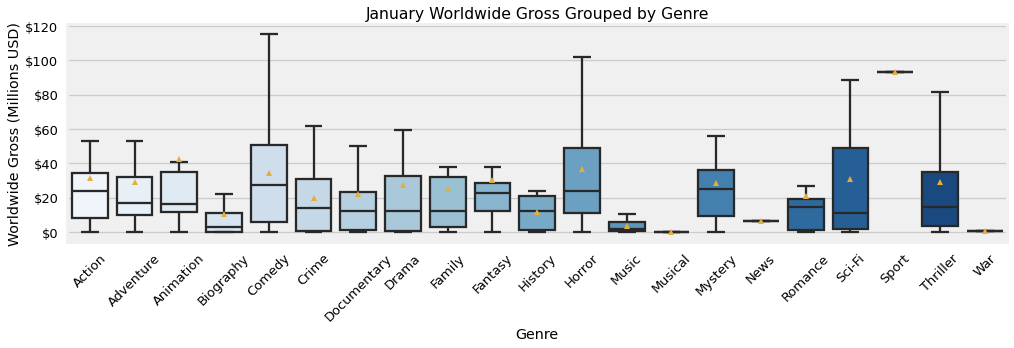

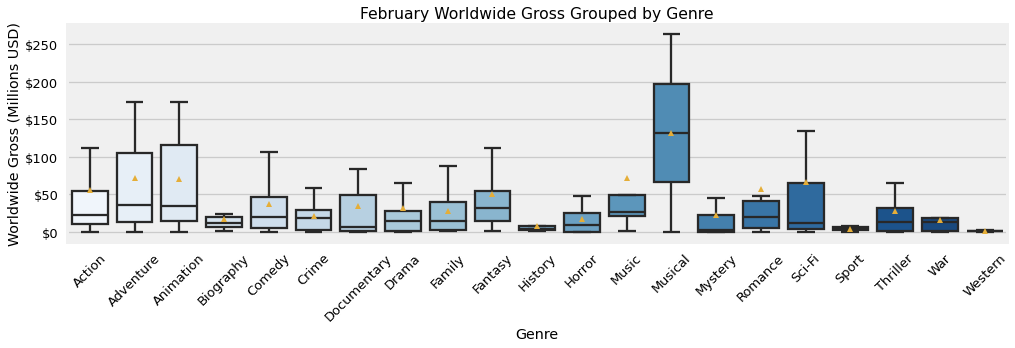

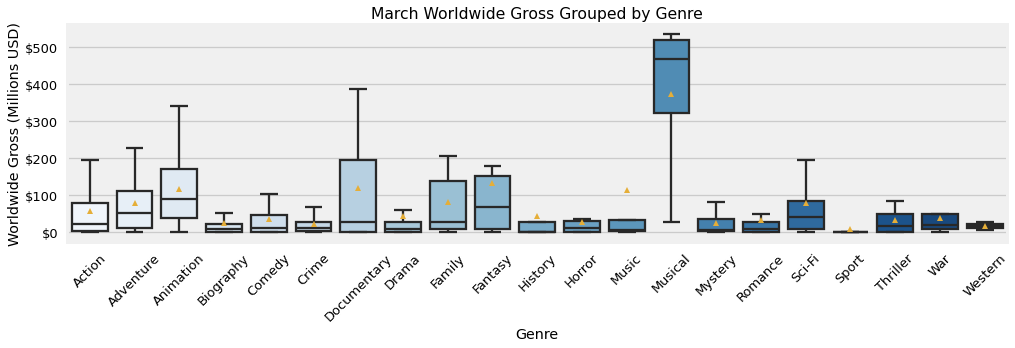

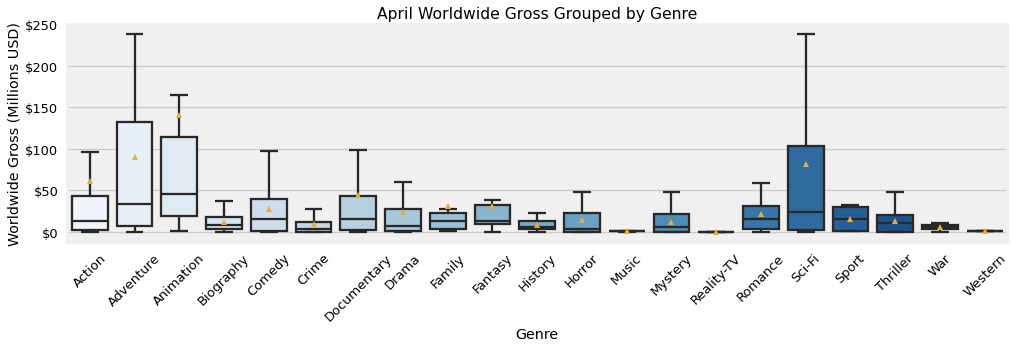

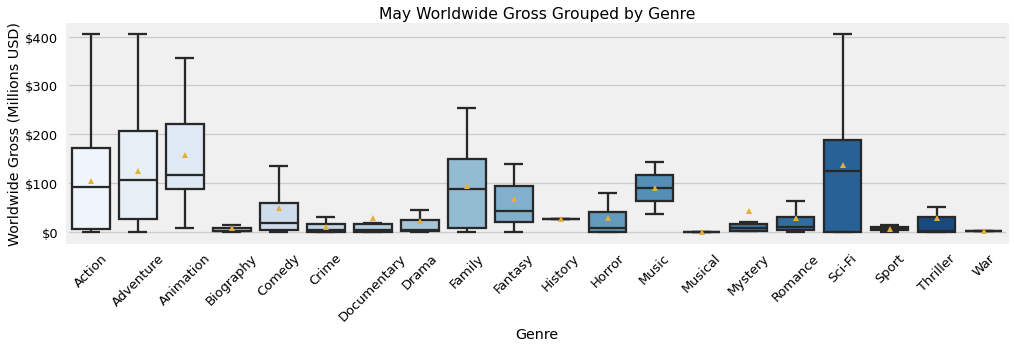

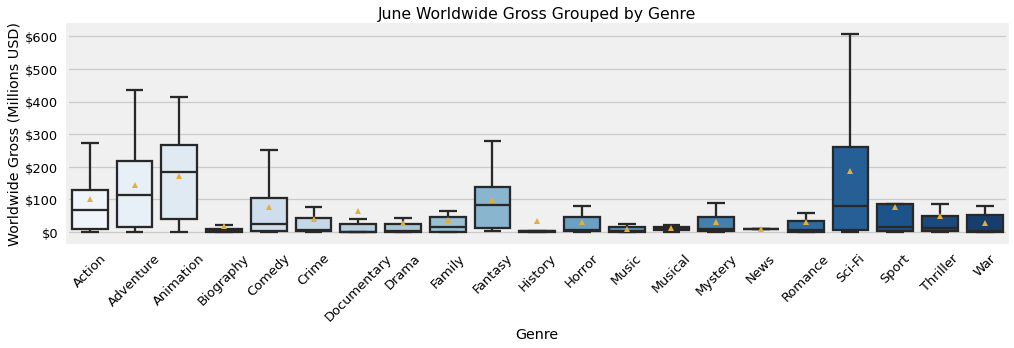

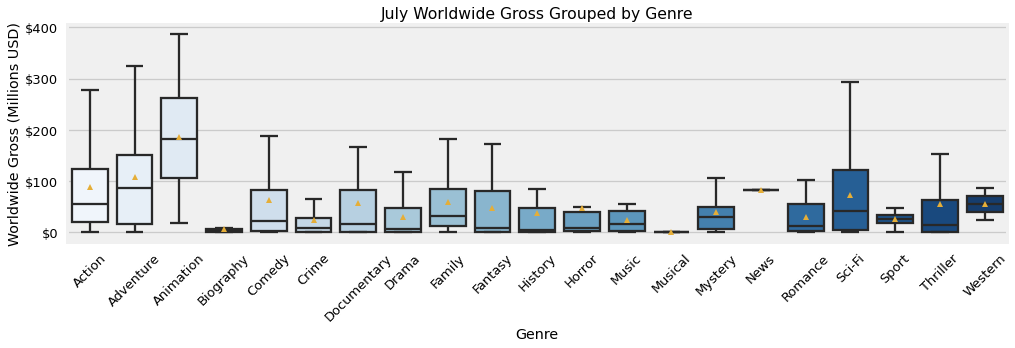

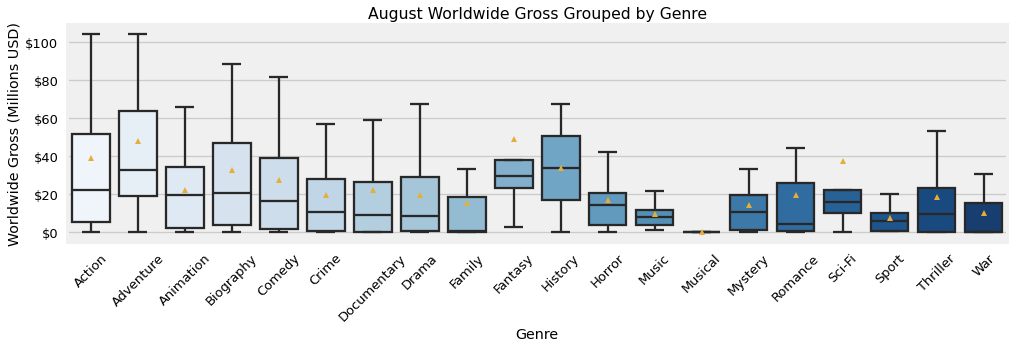

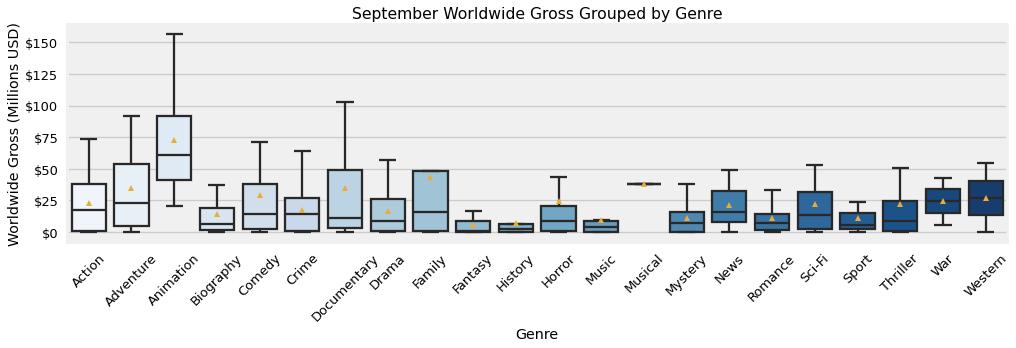

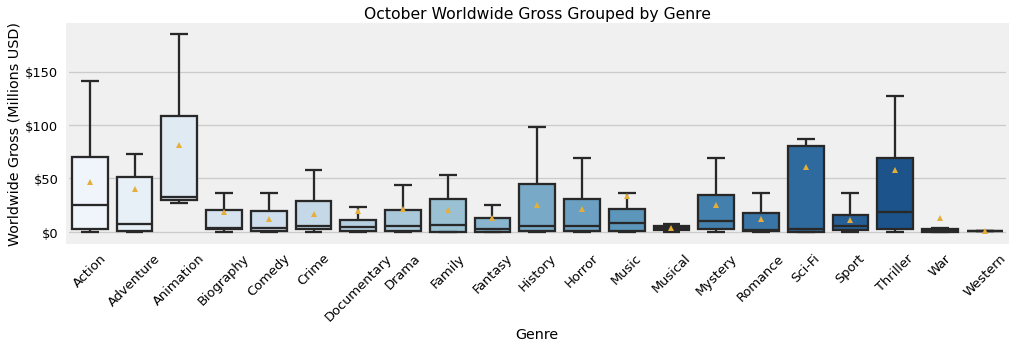

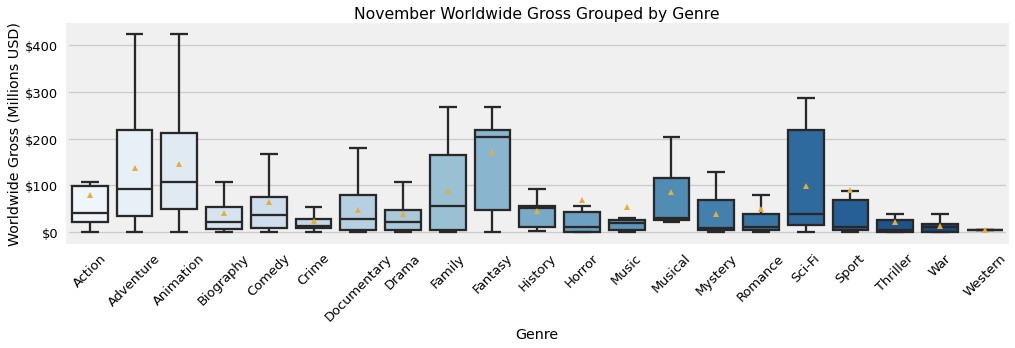

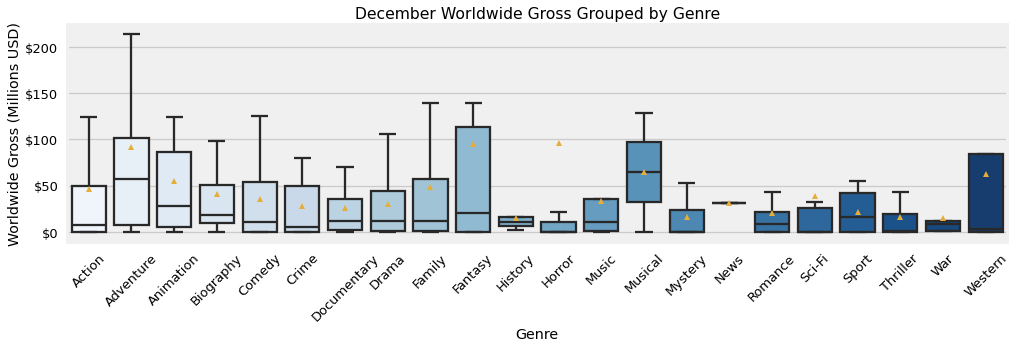

In [36]:
# create for loop to iterate over the months and plot each month individually
for key,val in months_words_ints.items():
# ----------seperate by month----------------------------------------
    DF = tnimdb_sql[tnimdb_sql['p_month'] == val]

# ----------initiate plot--------------------------------------------
    fig, ax = plt.subplots(figsize=(15,4))
    sns.boxplot(x=DF['genres_exploded'], y=DF['gross_divided']/1000000, showfliers = False, \
                ax=ax, palette='Blues', showmeans=True)

# ----------Customize labels-----------------------------------------
    ax.set_title(f'{key} Worldwide Gross Grouped by Genre')
    ax.set_xlabel("Genre")
    ax.set_ylabel("Worldwide Gross (Millions USD)")
    ax.yaxis.set_major_formatter('${x:1.0f}') 
    ax.set_xticks(range(0, len(DF['genres_exploded'].unique())))
    ax.set_xticklabels(list(DF['genres_exploded'].unique()), rotation=45)
    ;

### To clarify some of those numbers:
#### Top 3 Genres by Month:
- __January:__ ('Sport', 'Animation', 'Horror')
- __February:__ ('Musical', 'Music', 'Adventure')
- __March:__ ('Musical', 'Fantasy', 'Documentary')
- __April:__ ('Animation', 'Adventure', 'Sci-Fi')
- __May:__ ('Animation', 'Sci-Fi', 'Adventure')
- __June:__ ('Sci-Fi', 'Animation', 'Adventure')
- __July:__ ('Animation', 'Adventure', 'Action')
- __August:__ ('Fantasy', 'Adventure', 'Action')
- __September:__ ('Animation', 'Family', 'Musical')
- __Ocotober:__ ('Animation', 'Sci-Fi', 'Thriller')
- __November:__ ('Fantasy', 'Animation', 'Adventure')
- __December:__ ('Horror', 'Fantasy', 'Adventure')

*scroll to bottom of notebook for more info*

### Worldwide Gross grouped by Rating: 
*(very limited dataset, only 33 films)*

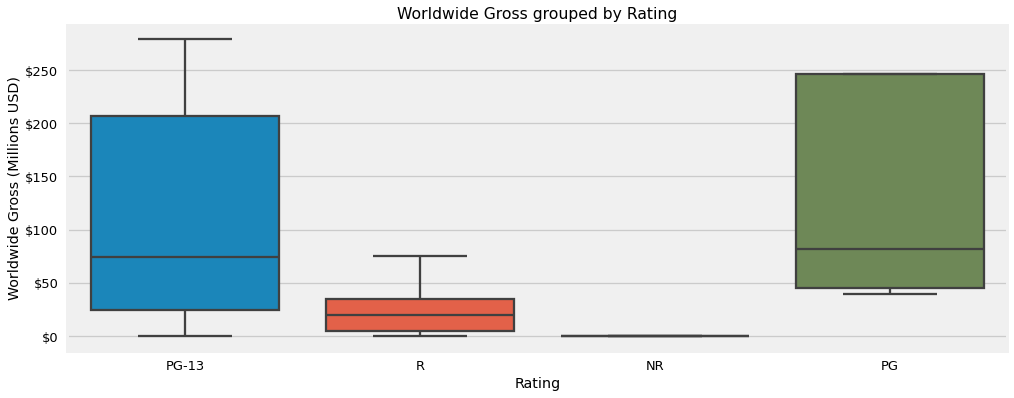

In [37]:
# initiate plot
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=rttnimdb['rating'], y=rttnimdb['p_ww_gross']/1000000, showfliers = False, ax=ax)

# customize labels
ax.set_title('Worldwide Gross grouped by Rating')
ax.set_xlabel("Rating")
ax.set_ylabel("Worldwide Gross (Millions USD)")
ax.yaxis.set_major_formatter('${x:1.0f}')

### Correlation Between Production Budget & Worldwide Gross, Grouped by Rating: 
*(same very limited dataset, only 33 films)*

''

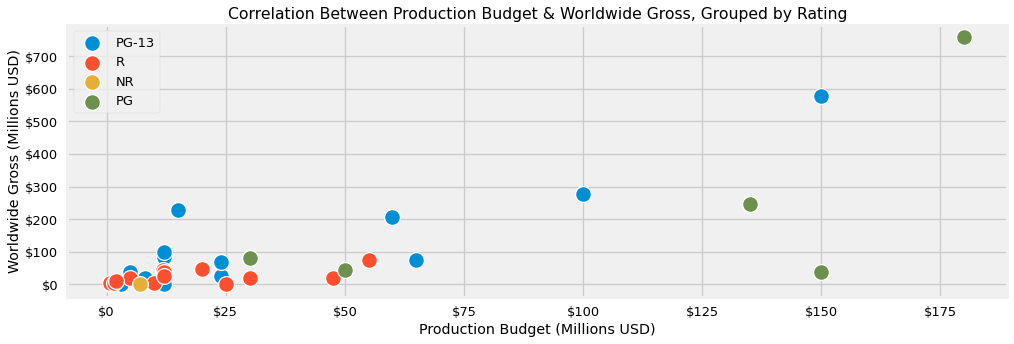

In [38]:
# initiate plot
fig, ax = plt.subplots(figsize=(15,5))
x, y = (rttnimdb['p_prod_budg'], rttnimdb['p_ww_gross'])

for rating in rttnimdb['rating'].unique():
    subset = rttnimdb[rttnimdb['rating'] == rating]
    x = subset['p_prod_budg']/1000000
    y = subset['p_ww_gross']/1000000
    
  #  ax.scatter(x, y, label=rating)
    sns.scatterplot(x=x, y=y, ax=ax, label=rating, s=250)

# customize labels
ax.set_xlabel('Production Budget (Millions USD)')
ax.xaxis.set_major_formatter('${x:1.0f}') 
ax.set_ylabel('Worldwide Gross (Millions USD)')
ax.yaxis.set_major_formatter('${x:1.0f}') 
ax.set_title('Correlation Between Production Budget & Worldwide Gross, Grouped by Rating')
;

# Results
- Production Budget, Month of Release, Genre, and Rating were all positively correlated with Worldwide Gross. 
- Production Budget has the strongest correlation with Worldwide Gross
- May & June are top two grossing months followed by July & November
- Animation & Adventure are in all those months’ Top 3 Genres
- May & June have the same top 3 Genres just in different order
- Based on the mean value, PG is the top grossing movie rating.
- An R rating seems to significantly limit worldwide gross however, on closer inspection it appears R rated movies do not have large production budgets which may also be restricting the worldwide gross. More data is needed for further analysis.

 

# Conclusions
Deciding to fund a film can be risky, by understanding the correlation between worldwide gross and the aforementioned factors TMPC can optimism revenue potential by aligning all positively correlated factors.

-	__Bank on the budget:__ higher production budget yields higher worldwide gross
-	__The month matters:__ May & June are the top two months to release a film
-	__Each months top genres matter too:__ May & June have the same top 3 genres: Animation, Sci-Fi, & Adventure 
-	__R is NOT for Revenue… maybe?__ R rated movies restrict your audience, potentially restricting your worldwide gross


## Next Steps
1. Release a film in May or June
2. The film should contain one of the following genres:
 - Adventure
 - Animation
 - Sci-Fi 
3. The movie should be rated PG
4. Don’t shy away from higher production cost to increase Worldwide Gross.

### _Limitations to consider._
- This analysis was based strictly on worldwide gross and does not reflect other factors which influence profitability of a film. A few examples being: postproduction costs, merchandising income, marketing, return on investment, foreign rights, distribution fees… etc. 
- Investigation into the return on investment (in this case difference between worldwide gross and production budget) may yeild additional insight into ideal genres, ratings, or months-of-release.
- The data frames contain films dating back a century. Further analysis is needed to measure if the analysis is skewed (specifically the Musical genre) by these older films and not reflective current trends. 
- No calculations to account for inflation were done.

# Just the numbers: 
## Pearson correlation between worldwide gross and:
- __Production Budget:__ 0.748
- __Month of Release:__ 0.030
- __Rating:__ 0.151
- __Genre:__ 0.144



In [39]:
# PRODUCTION BUDGET ######################################
# ----------correlation between worldwide gross and production budget------------
budget_gross_corr = tn['p_ww_gross'].corr(tn['p_prod_budg'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between production budget to worldwide gross: {round(budget_gross_corr,3)}")


# MONTH OF RELEASE ######################################
# ----------correlation between month of release and wwgross---------------------
month_gross_corr = tn['p_ww_gross'].corr(tn['p_month'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between month of release and worldwide gross: {round(month_gross_corr,3)}")


# RATING ##############################################
# to evaluate corr between gross and rating, assign rating string an int value 

# ----------get unique values---------------------------------------------------
unique_ratings = rttnimdb['rating'].unique() 

# ----------make list of int values == to length of unique ratings--------------
rating_ints = [index for index in range(len(unique_ratings))]

# ----------make ditionary with unique values as keys and integers as values----
rating_int_dict = {unique_ratings[i]: rating_ints[i] for i in range(len(rating_ints))}

# ----------make list to assign to new column-----------------------------------
rating_int_col = [rating_int_dict[rating] for rating in rttnimdb['rating']]

# ----------add new column------------------------------------------------------
rttnimdb['rating_int'] = rating_int_col

# ----------correlation between worldwide gross and ratings values--------------
rating_gross_corr = rttnimdb['p_ww_gross'].corr(rttnimdb['rating_int'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between rating and worldwide gross: {round(rating_gross_corr,3)}")


# GENRE ##############################################
# to evaluate corr between gross and genre, assign genre string an int value

# ----------get unique values---------------------------------------------------
unique_genres = tnimdb['genres_exploded'].unique()

# ----------make list of integers == to length of unique ratings----------------
genre_ints = [index for index in range(len(unique_genres))]

# ----------make ditionary with unique values as keys and integers as values----
genre_int_dict = {unique_genres[i]: genre_ints[i] for i in range(len(genre_ints))}

# ----------make list to assign to new column-----------------------------------
genre_int_col = [genre_int_dict[genre] for genre in tnimdb['genres_exploded']]

# ----------add new column------------------------------------------------------
tnimdb['genre_int'] = genre_int_col

# ----------correlation between worldwide gross and ratings values--------------
genre_gross_corr = tnimdb['p_ww_gross'].corr(tnimdb['genre_int'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between rating and worldwide gross: {round(genre_gross_corr,3)}")

The Pearson correlation between production budget to worldwide gross: 0.748
The Pearson correlation between month of release and worldwide gross: 0.03
The Pearson correlation between rating and worldwide gross: 0.151
The Pearson correlation between rating and worldwide gross: 0.144


## More numbers:
- Min
- Max
- Median
- Mean
- Standard Deviation


### For the following:

- Production Budget
- Worldwide Gross
- Production Budget by Rating
- Production Budget by Genre
- Worldwide Gross by Rating
- Worldwide Gross by Genre (using divided worldwide gross)
- Worldwide Gross by Month

In [40]:
# descriptive statistics for all features used in the analysis
# features used: 
    #production budget (tn)
print("PRODUCTION BUDGET:")
print(f"Min: {tn['p_prod_budg'].min()}, Max: {tn['p_prod_budg'].max()}, Median: {tn['p_prod_budg'].median()}, Mean: {tn['p_prod_budg'].mean()}, Standard Deviation: {tn['p_prod_budg'].std()}")
print()
print()
    #worldwide gross (tn)
print("WORLDWIDE GROSS:")
print(f"Min: {tn['p_ww_gross'].min()}, Max: {tn['p_ww_gross'].max()}, Median: {tn['p_ww_gross'].median()}, Mean: {tn['p_ww_gross'].mean()}, Standard Deviation: {tn['p_ww_gross'].std()}")
print()
print()
    # production budget by rating (rttnimdb)
print("PRODUCTION BUDGET BY RATING:")
for rating in rttnimdb['rating'].unique():
    subset = rttnimdb[rttnimdb['rating'] == rating]
    print(rating)
    print(f"Min: {subset['p_prod_budg'].min()}, Max: {subset['p_prod_budg'].max()}, Median: {subset['p_prod_budg'].median()}, Mean: {subset['p_prod_budg'].mean()}, Standard Deviation: {subset['p_prod_budg'].std()}")
print()
    # production budget by genre (tnimdb)
print()
print("PRODUCTION BUDGET BY GENRE:")
for genre in tnimdb['genres_exploded'].unique():
    subset = tnimdb[tnimdb['genres_exploded'] == genre]
    print(genre)
    print(f"Min: {subset['p_prod_budg'].min()}, Max: {subset['p_prod_budg'].max()}, Median: {subset['p_prod_budg'].median()}, Mean: {subset['p_prod_budg'].mean()}, Standard Deviation: {subset['p_prod_budg'].std()}")
print()
    # ww gross by rating (rttnimdb)
print()
print("WORLDWIDE GROSS BY RATING:")
for rating in rttnimdb['rating'].unique():
    subset = rttnimdb[rttnimdb['rating'] == rating]
    print(rating)
    print(f"Min: {subset['p_ww_gross'].min()}, Max: {subset['p_ww_gross'].max()}, Median: {subset['p_ww_gross'].median()}, Mean: {subset['p_ww_gross'].mean()}, Standard Deviation: {subset['p_ww_gross'].std()}")
print()
    # ww gross by genre (tnimdb)
print()
print("WORLDWIDE GROSS BY GENRE (using films gross divided by films number of genres):")
for genre in tnimdb['genres_exploded'].unique():
    subset = tnimdb[tnimdb['genres_exploded'] == genre]
    print(genre)
    print(f"Min: {subset['gross_divided'].min()}, Max: {subset['gross_divided'].max()}, Median: {subset['gross_divided'].median()}, Mean: {subset['gross_divided'].mean()}, Standard Deviation: {subset['gross_divided'].std()}")
print()
    # ww gross by month (tnimdb)
print()
print("WORLDWIDE GROSS BY MONTH:")
for month in tnimdb['p_month'].unique():
    subset = tnimdb[tnimdb['p_month'] == month]
    print(month)
    print(f"Min: {subset['p_ww_gross'].min()}, Max: {subset['p_ww_gross'].max()}, Median: {subset['p_ww_gross'].median()}, Mean: {subset['p_ww_gross'].mean()}, Standard Deviation: {subset['p_ww_gross'].std()}")
print()
print()
print("WORLDWIDE GROSS of GENRES by MONTH (using films gross divided by films number of genres):")
    # ww gross of genres by month -using gross divided by number of genres- (tnimdb)
for key,val in months_words_ints.items():
    DF = tnimdb[tnimdb['p_month'] == val]
    print()
    print(f'################# {key} #################')
    for genre in DF['genres_exploded'].unique():
        subset = DF[DF['genres_exploded'] == genre]
        print(genre)
        print(f"Min: {subset['gross_divided'].min()}, Max: {subset['gross_divided'].max()}, Median: {subset['gross_divided'].median()}, Mean: {subset['gross_divided'].mean()}, Standard Deviation: {subset['gross_divided'].std()}")
    

PRODUCTION BUDGET:
Min: 1100, Max: 425000000, Median: 17000000.0, Mean: 31587757.0965064, Standard Deviation: 41812076.82694309


WORLDWIDE GROSS:
Min: 0, Max: 2776345279, Median: 27984448.5, Mean: 91487460.90643376, Standard Deviation: 174719968.77890477


PRODUCTION BUDGET BY RATING:
PG-13
Min: 3000000, Max: 150000000, Median: 15000000.0, Mean: 37692307.692307696, Standard Deviation: 44499783.92341663
R
Min: 750000, Max: 55000000, Median: 11900000.0, Mean: 16682142.857142856, Standard Deviation: 17254181.28970546
NR
Min: 7000000, Max: 7000000, Median: 7000000.0, Mean: 7000000.0, Standard Deviation: nan
PG
Min: 30000000, Max: 180000000, Median: 135000000.0, Mean: 109000000.0, Standard Deviation: 65421708.9351845


PRODUCTION BUDGET BY GENRE:
Crime
Min: 25000, Max: 175000000, Median: 20000000.0, Mean: 25812710.841954023, Standard Deviation: 24451850.753775604
Drama
Min: 1400, Max: 210000000, Median: 13000000.0, Mean: 23316683.864651773, Standard Deviation: 30476185.80667961
Horror
Min:

Min: 0, Max: 172533047, Median: 16418027.5, Mean: 42731829.5, Standard Deviation: 64998879.575741
Adventure
Min: 0, Max: 172533047, Median: 16788499.0, Mean: 29309120.789473683, Standard Deviation: 40768669.978158034
Documentary
Min: 0, Max: 148095566, Median: 11963668.0, Mean: 22132383.791666668, Standard Deviation: 35914308.99160855
Crime
Min: 0, Max: 81767835, Median: 14123434.5, Mean: 19896922.692307692, Standard Deviation: 21600278.01224468
Thriller
Min: 0, Max: 139482403, Median: 14448210.5, Mean: 28769439.944444444, Standard Deviation: 35973834.589744575
Biography
Min: 0, Max: 57796052, Median: 2722420.0, Mean: 10579702.1, Standard Deviation: 18093022.755838398
Sci-Fi
Min: 0, Max: 122651752, Median: 10969812.0, Mean: 31007070.727272727, Standard Deviation: 44242429.68869433
Musical
Min: 91433, Max: 91433, Median: 91433.0, Mean: 91433.0, Standard Deviation: nan
Romance
Min: 0, Max: 92988268, Median: 14199183.5, Mean: 20970721.5, Standard Deviation: 27865993.17354016
Horror
Min: 0

Min: 0, Max: 0, Median: 0.0, Mean: 0.0, Standard Deviation: nan
Western
Min: 934964, Max: 934964, Median: 934964.0, Mean: 934964.0, Standard Deviation: nan

################# May #################
Comedy
Min: 0, Max: 293232152, Median: 19079300.0, Mean: 49892484.315789476, Standard Deviation: 72314783.31083517
Romance
Min: 0, Max: 175520209, Median: 9943469.0, Mean: 28462873.633333333, Standard Deviation: 42532697.65933158
Drama
Min: 0, Max: 195057182, Median: 3803217.0, Mean: 21668719.226190478, Standard Deviation: 40434817.408337265
Fantasy
Min: 366762, Max: 262747045, Median: 42514252.0, Mean: 67907966.25, Standard Deviation: 75745465.8744673
Action
Min: 0, Max: 405130757, Median: 91796100.5, Mean: 105055912.04761904, Standard Deviation: 109164048.28433384
Adventure
Min: 0, Max: 405130757, Median: 105989453.5, Mean: 123837444.05555555, Standard Deviation: 109011013.55785072
Family
Min: 4488, Max: 252845578, Median: 87598147.0, Mean: 93210960.45454545, Standard Deviation: 90088896.62

Min: 0, Max: 103522054, Median: 13631174.0, Mean: 21954452.25, Standard Deviation: 27415470.159976672
Crime
Min: 0, Max: 64301208, Median: 13822535.0, Mean: 17296373.56097561, Standard Deviation: 17991723.914933875
Action
Min: 0, Max: 136267898, Median: 17266919.0, Mean: 23217646.272727273, Standard Deviation: 28082944.91358184
Adventure
Min: 0, Max: 136267898, Median: 23232831.0, Mean: 34512912.217391305, Standard Deviation: 35307100.924595475
Biography
Min: 607, Max: 73765687, Median: 6093550.5, Mean: 14430298.454545455, Standard Deviation: 18918541.766108833
Family
Min: 19898, Max: 156500099, Median: 15790397.0, Mean: 43063483.666666664, Standard Deviation: 58346077.92321063
History
Min: 0, Max: 25323708, Median: 2264256.0, Mean: 6751407.6, Standard Deviation: 10680747.776361648
Music
Min: 0, Max: 38681449, Median: 4185654.5, Mean: 9355944.0, Standard Deviation: 14989792.98142977
News
Min: 161312, Max: 49115419, Median: 15576859.0, Mean: 21617863.333333332, Standard Deviation: 25029

## And even more numbers:

### Top ranking genres (determined by highest means of genres divided-gross, which is a films worldwide gross divided equally amoung its genres)

#### Top 3 Genres by Month:
- __January:__ ('Sport', 'Animation', 'Horror')
- __February:__ ('Musical', 'Music', 'Adventure')
- __March:__ ('Musical', 'Fantasy', 'Documentary')
- __April:__ ('Animation', 'Adventure', 'Sci-Fi')
- __May:__ ('Animation', 'Sci-Fi', 'Adventure')
- __June:__ ('Sci-Fi', 'Animation', 'Adventure')
- __July:__ ('Animation', 'Adventure', 'Action')
- __August:__ ('Fantasy', 'Adventure', 'Action')
- __September:__ ('Animation', 'Family', 'Musical')
- __Ocotober:__ ('Animation', 'Sci-Fi', 'Thriller')
- __November:__ ('Fantasy', 'Animation', 'Adventure')
- __December:__ ('Horror', 'Fantasy', 'Adventure')

In [41]:
for key,val in months_words_ints.items():
    
    # seperate by month
    DF = tnimdb[tnimdb['p_month'] == val]
    
    # make tuples list with genres as values and 'gross_divided' mean as keys
    Genre = []
    Mean = []
    for genre in DF['genres_exploded'].unique():
        subset = DF[DF['genres_exploded'] == genre]
        Mean.append(subset['gross_divided'].mean())
        Genre.append(genre)
        
    info_tuples = list(zip(Mean, Genre))
    ranked_info = sorted(info_tuples, reverse=True)
    top = ranked_info[:3]
    top_unzip = list(zip(*top))
    values = top_unzip[0]
    names = top_unzip[1]
    
    print(f"{key} top 3 genres are: {names}")

January top 3 genres are: ('Sport', 'Animation', 'Horror')
February top 3 genres are: ('Musical', 'Music', 'Adventure')
March top 3 genres are: ('Musical', 'Fantasy', 'Documentary')
April top 3 genres are: ('Animation', 'Adventure', 'Sci-Fi')
May top 3 genres are: ('Animation', 'Sci-Fi', 'Adventure')
June top 3 genres are: ('Sci-Fi', 'Animation', 'Adventure')
July top 3 genres are: ('Animation', 'Adventure', 'Action')
August top 3 genres are: ('Fantasy', 'Adventure', 'Action')
September top 3 genres are: ('Animation', 'Family', 'Musical')
October top 3 genres are: ('Animation', 'Sci-Fi', 'Thriller')
November top 3 genres are: ('Fantasy', 'Animation', 'Adventure')
December top 3 genres are: ('Horror', 'Fantasy', 'Adventure')


# Questions...

### Thank you!

__Email:__ cassigroesbeck@gmail.com

__GitHub:__ @AgathaZareth

__LinkedIn:__ linkedin.com/in/cassarra-groesbeck-a64b75229
